In [ ]:
!wget --no-check-certificate -r  'https://drive.usercontent.google.com/download?id=1dnSBWAeQzsLBwrGOnnrOwOpQEtbq8jvz&export=download&authuser=0&confirm=t&uuid=ec019574-b5f2-4311-9fcf-7739790674a3&at=APZUnTXFwcjMnkpjP8vUUVOgFVNs:1702211221829'

In [ ]:
!mv /content/drive.usercontent.google.com /content/dataset
!mv /content/dataset/'download?id=1dnSBWAeQzsLBwrGOnnrOwOpQEtbq8jvz&export=download&authuser=0&confirm=t&uuid=ec019574-b5f2-4311-9fcf-7739790674a3&at=APZUnTXFwcjMnkpjP8vUUVOgFVNs:1702211221829' /content/dataset/flowers.7z
!sudo apt update
!sudo apt install p7zip-full
!7za x /content/dataset/flowers.7z
!rm -rf dataset

In [17]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage.feature import hog

In [19]:
def load_data(directory):
    images = []
    labels = []
    for label, flower_type in enumerate(os.listdir(directory)):
        for filename in os.listdir(os.path.join(directory, flower_type)):
            img_path = os.path.join(directory, flower_type, filename)
            images.append(img_path)
            labels.append(label)
    return np.array(images), np.array(labels)


In [28]:
def process_image(image_path, resize_width=64, resize_height=64):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (resize_width, resize_height))

    if img.shape[-1] == 3:
          img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = hog(img, visualize=False)

    return img

In [29]:
def extract_features(images):
    features = [process_image(img) for img in images]
    return np.array(features)

In [30]:
directory = "/content/flowers"
images, labels = load_data(directory)
features = extract_features(images)

In [31]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
model = LogisticRegression(max_iter=10000, solver='lbfgs')  # Adjust max_iter and solver
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=10000)

In [33]:
y_pred = model.predict(X_test_scaled)

In [34]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.3900462962962963
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.42      0.44       205
           1       0.49      0.47      0.48       218
           2       0.27      0.29      0.28       160
           3       0.35      0.42      0.38       135
           4       0.35      0.32      0.33       146

    accuracy                           0.39       864
   macro avg       0.38      0.38      0.38       864
weighted avg       0.39      0.39      0.39       864



In [35]:
model_filename = "flower_classification_model.joblib"
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")

Model saved to flower_classification_model.joblib


In [36]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

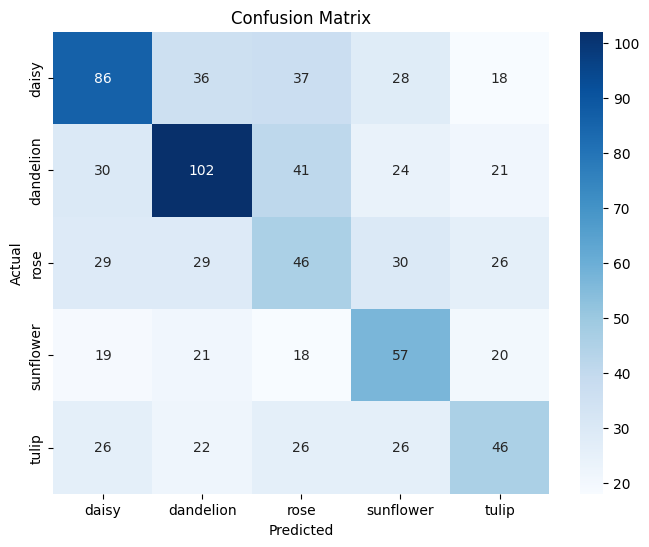

In [37]:
plot_confusion_matrix(y_test, y_pred, class_names=["daisy", "dandelion", "rose", "sunflower", "tulip"])


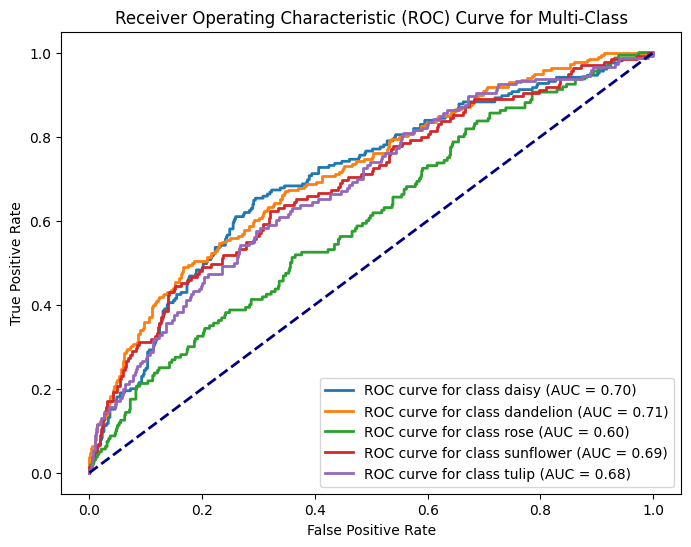

In [38]:
from sklearn.metrics import roc_auc_score

# Predict probabilities for each class
y_probs = model.predict_proba(X_test_scaled)
class_names=["daisy", "dandelion", "rose", "sunflower", "tulip"]
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
plt.legend(loc='lower right')
plt.show()